### This is replication code for ECON 220D Assignment 1
- The main goal of this project is to summarize the key features of fiscal policy and macroeconomic variables. 
- The next step is to identify fiscal policy shocks and evaluate their effects on economic stabilization. I am also interested in comparing the impacts of fiscal and monetary policies on economic stability, particularly during “normal” periods and major recessions.

In [201]:
# Set Up
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from fredapi import Fred

#### Upload Dataset
There are two main type of data
- Fiscal Policy-related
(Maybe Monetary Polict-related)
- Macroeconomic variables: GDP, Consumptionl, Unemployment Rate, Inflation Rate


In [202]:
dt_quarterly = pd.read_csv('../Data/quarterly.csv')
dt_monthly = pd.read_csv('../Data/monthly.csv')
dt_CPI = pd.read_excel('../Data/CPI.xlsx')

/Users/jie/Library/Python/3.12/lib/python/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [203]:
# CPI Data: convert to quarterly data and have 2017 as the base year
dt_CPI=dt_CPI.loc[10:, :]
new_header = dt_CPI.iloc[0]
dt_CPI = dt_CPI[1:]                
dt_CPI.columns = new_header        
dt_CPI = dt_CPI.reset_index(drop=True)
# Convert to quarterly data by taking the average of the monthly data
month_cols = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct',
'Nov','Dec']
dt_CPI_quarterly = (
    dt_CPI.assign(
        Q1 = dt_CPI[['Jan','Feb','Mar']].mean(axis=1),
        Q2 = dt_CPI[['Apr','May','Jun']].mean(axis=1),
        Q3 = dt_CPI[['Jul','Aug','Sep']].mean(axis=1),
        Q4 = dt_CPI[['Oct','Nov','Dec']].mean(axis=1)
    )[["Year","Q1","Q2","Q3","Q4"]]
)
cpi_2017 = dt_CPI_quarterly.loc[dt_CPI_quarterly['Year'] == 2017].iloc[-1]
dt_CPI_2017 = dt_CPI_quarterly.copy()
dt_CPI_2017['Q1'] = cpi_2017[1]/dt_CPI_2017['Q1']
dt_CPI_2017['Q2'] = cpi_2017[2]/dt_CPI_2017['Q2']
dt_CPI_2017['Q3'] = cpi_2017[3]/dt_CPI_2017['Q3']
dt_CPI_2017['Q4'] = cpi_2017[4]/dt_CPI_2017['Q4']
dt_CPI_long = (dt_CPI_2017
               .melt(id_vars='Year',
                     value_vars=['Q1','Q2','Q3','Q4'],
                     var_name='Quarter',
                     value_name='CPI')
               .sort_values(['Year','Quarter'])
               .reset_index(drop=True))

/var/folders/7l/s2f7b2zs6mn_2bgdqdbsmzqw0000gn/T/ipykernel_12872/2603251368.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dt_CPI_2017['Q1'] = cpi_2017[1]/dt_CPI_2017['Q1']
/var/folders/7l/s2f7b2zs6mn_2bgdqdbsmzqw0000gn/T/ipykernel_12872/2603251368.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dt_CPI_2017['Q2'] = cpi_2017[2]/dt_CPI_2017['Q2']
/var/folders/7l/s2f7b2zs6mn_2bgdqdbsmzqw0000gn/T/ipykernel_12872/2603251368.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To

In [204]:
# Monthly Data: Federal Funds Rate and Unemployment Rate : Convert to quarterly data
dt_monthly['observation_date'] = pd.to_datetime(dt_monthly['observation_date'])
dt_monthly['Year'] = dt_monthly['observation_date'].dt.year
pattern = np.repeat(['Q1','Q2','Q3','Q4'],3)
dt_monthly['Quarter']=np.tile(pattern, len(dt_monthly) // 12 + 1)[:len(dt_monthly)]
Rate_quarterly=dt_monthly.copy()
Rate_quarterly = (dt_monthly
                  .groupby(['Year','Quarter'], as_index=False)
                  .mean(numeric_only=True)
                  .sort_values(['Year','Quarter']))

In [205]:
# quarterly data: Assign the column names
col_names = ['observation_date', 'Transfer_payments', 'Interest_payments', 
'Tax_corp_Federal', 'Tax_corp_Staloc', 'Gov_Expenditure', 'RGDP',
'Per_Consumption', 'Import_tax_Fed', 'Personal_tax', 'Import_tax_Staloc',
'Cont_SocialInsurance']
dt_quarterly.columns = col_names
dt_quarterly['observation_date'] = pd.to_datetime(dt_quarterly['observation_date'])
dt_quarterly['Year'] = dt_quarterly['observation_date'].dt.year
pattern = ['Q1','Q2','Q3','Q4']
dt_quarterly['Quarter']=np.tile(pattern, len(dt_quarterly) // 4 + 1)[:len(dt_quarterly)]
dt_quarterly = dt_quarterly.merge(dt_CPI_long, on=['Year','Quarter'], how='left')
# Note that some variables are based on 2017 prices while others are not
# - 2017 prices: Gov_Expenditure, RGDP
cols = ['Transfer_payments', 'Interest_payments', 
'Tax_corp_Federal', 'Tax_corp_Staloc', 'Per_Consumption', 
'Import_tax_Fed', 'Personal_tax', 'Import_tax_Staloc',
'Cont_SocialInsurance']
dt_quarterly[cols] = dt_quarterly[cols].multiply(dt_quarterly['CPI'], axis=0)

In [206]:
# Calculate net taxes and government expenditure
# net taxes = Personal tax + Corp Tax + Import tax + Cont_SocialInsurance - Transfer_payments - Interest_payments
# government expenditure = Gov_Expenditure
dt_quarterly['Net_Taxes'] = dt_quarterly['Personal_tax'] + dt_quarterly['Tax_corp_Federal']  + dt_quarterly['Tax_corp_Staloc']+ dt_quarterly['Import_tax_Fed'] + dt_quarterly['Import_tax_Staloc'] + dt_quarterly['Cont_SocialInsurance'] - dt_quarterly['Transfer_payments'] - dt_quarterly['Interest_payments']

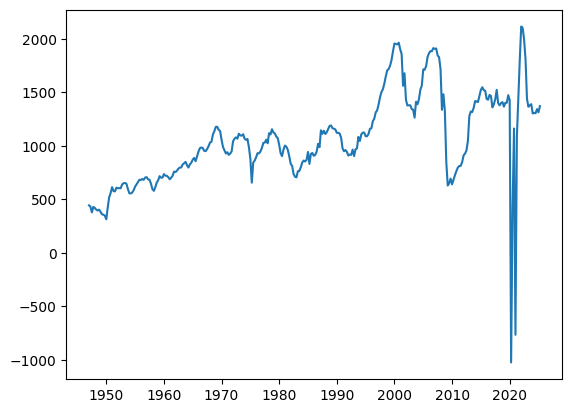

In [207]:
plt.plot(dt_quarterly['observation_date'], dt_quarterly['Net_Taxes'])

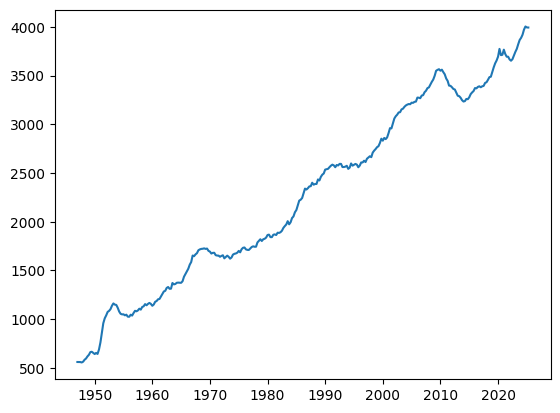

In [208]:
plt.plot(dt_quarterly['observation_date'], dt_quarterly['Gov_Expenditure'])

In [209]:
dt_quarterly.head()

,observation_date,Transfer_payments,Interest_payments,Tax_corp_Federal,Tax_corp_Staloc,Gov_Expenditure,RGDP,Per_Consumption,Import_tax_Fed,Personal_tax,Import_tax_Staloc,Cont_SocialInsurance,Year,Quarter,CPI,Net_Taxes
0,1947-01-01,105.0866,66.308386,122.21149,6.966819,560.515,2182.681,1754.750692,87.557184,215.353366,111.09829,71.331238,1947,Q1,11.236805,443.123402
1,1947-04-01,101.995798,65.60517,114.196253,6.477332,560.091,2176.892,1774.955371,83.539838,216.003498,113.220216,66.148645,1947,Q2,11.091322,431.984814
2,1947-07-01,142.351531,64.533712,110.635453,6.325765,560.034,2172.432,1783.680384,80.882543,215.086924,115.77241,56.277498,1947,Q3,10.906492,378.09535
3,1947-10-01,108.103518,64.261298,118.02441,6.75647,555.556,2206.452,1792.517116,84.626923,222.354141,118.216842,51.143911,1947,Q4,10.690617,428.757881
4,1948-01-01,106.428609,62.630572,117.207758,6.773105,563.895,2239.682,1759.066252,77.849409,218.866283,117.940822,50.054899,1948,Q1,10.324855,419.633095


In [ ]:
# merge all the data
df_final1 = dt_quarterly.loc[:,['Net_Taxes', 'Gov_Expenditure', 'RGDP', 'Per_Consumption', 'Year', 'Quarter']]
df_final1['Date'] = df_final1['Year'].astype(str) + '_' + df_final1['Quarter'].astype(str)
df_final1=df_final1.loc[:,['Date', 'Net_Taxes', 'Gov_Expenditure', 'RGDP', 'Per_Consumption']]
Rate_quarterly['Date'] = Rate_quarterly['Year'].astype(str) + '_' + Rate_quarterly['Quarter'].astype(str)
Rate_quarterly = Rate_quarterly.loc[:,['Date', 'FEDFUNDS', 'UNRATE']]
dt_CPI_quarterly = (dt_CPI_quarterly
               .melt(id_vars='Year',
                     value_vars=['Q1','Q2','Q3','Q4'],
                     var_name='Quarter',
                     value_name='CPI')
               .sort_values(['Year','Quarter'])
               .reset_index(drop=True))
dt_CPI_quarterly['Date'] = dt_CPI_quarterly['Year'].astype(str) + '_' + dt_CPI_quarterly['Quarter'].astype(str)
dt_CPI_quarterly = dt_CPI_quarterly.loc[:,['Date', 'CPI']]
df_final = df_final1.merge(Rate_quarterly, on='Date', how='left').merge(dt_CPI_quarterly, on='Date', how='left')
df_final = df_final.loc[:,['Date', 'Net_Taxes', 'Gov_Expenditure', 'FEDFUNDS', 'RGDP', 'Per_Consumption', 'UNRATE', 'CPI']]